# 世界モデルを用いて, 画像入力タスクを解いてみよう！

本演習では, いわゆる世界モデルを用いた強化学習アルゴリズムの一つである [Dreamer](https://arxiv.org/abs/1912.01603) (Danijar Hafner, Timothy Lillicrap, Jimmy Ba, Mohammad Norouzi,
"Dream to Control: Learning Behaviors by Latent Imagination", ICLR2020) を用いて, PyBulletのHalfCheetahBulletEnv-v0を解いてみます.

実装のベースは [教材作成者の再現実装](https://github.com/cross32768/Dreamer_PyTorch) です.

0. [準備](#scrollTo=yDN8Ohc0Mh8C)
1. [環境の設定](#scrollTo=_eayBK1HPV5H)
2. [補助機能の実装](#scrollTo=WhlVvU3aZ5FC)
3. [モデルの実装](#scrollTo=keAW0J-qS24Q)
4. [エージェントの実装](#scrollTo=GdKZ1S2_boOd)
5. [ハイパーパラメータの設定と学習の準備](#scrollTo=QUPWAkpyc9Z-)
6. [学習](#scrollTo=yUoI0l9Ee0Tp)
7. [結果の確認]()

## 0. 準備
まず, 演習を行うために必要な準備を行います.

この演習では, 環境として[PyBullet](https://github.com/bulletphysics/bullet3)を用います. PyBulletは`pip`を用いてインストールします.

In [1]:
# !pip install numpy==1.23.1
# !pip install setuptools==65.5.0 pip==21
# !pip install pybullet
# !pip install gym==0.21.0

必要なライブラリをインポートします. 今回使うライブラリは, PyBullet以外はColabでは最初から入っていますが, 手元の環境で行う場合はこれらのライブラリも`pip`等で事前にインストールする必要があります.

In [2]:
import time
import os

import gym
import pybullet_envs  # PyBulletの環境をgymに登録する

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_
from torch.utils.tensorboard import SummaryWriter

# 可視化のためにTensorBoardを用いるので, Colab上でTensorBoardを表示するための宣言を行う
# %load_ext tensorboard

今回の学習にはGPUが必要です．

以下のコードを実行して， 結果が'cuda'でなければ「ランタイム」 →　 「ランタイムのタイプを変更」でGPUモードに変更しましょう．

In [3]:
# torch.deviceを定義. この変数は後々モデルやデータをGPUに転送する時にも使います
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


きちんとGPUが使える状態になっているかチェックしておきます． ColabのGPU割り当てにはランダム性があるので人によって結果が違う場合がありますが， どれでも実行には問題ありません（学習にかかる時間に幾らかの差は出ます）

In [4]:
!nvidia-smi

Sun Mar  3 08:53:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. 環境の設定

環境を扱いやすくするために, いくつかラッパーを挟みます.

今回はPyBulletを画像入力の環境として用います. 環境を作成して, 画像がどのようになっているかを見てみましょう.

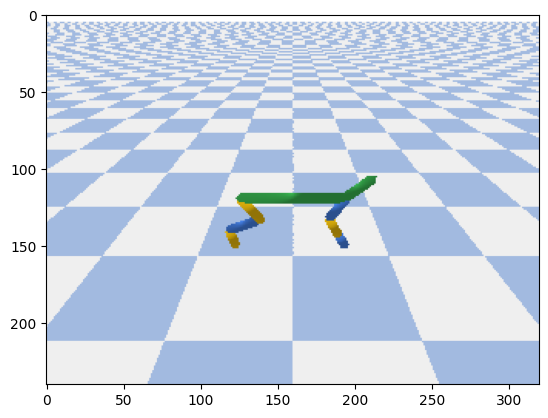

In [5]:
env = gym.make('HalfCheetahBulletEnv-v0')  # 環境を読み込む. 今回はHalfCheetah
env.reset()
image = env.render(mode='rgb_array')  # env.renderで画像を取得
plt.imshow(image)
plt.show()
env.close()

画像が無事表示されたでしょうか. 中央に見える２本足の何かを前方に走らせるのが今回のタスクです. ちょっとカメラの位置が遠いので, カメラの位置と角度を調整するラッパーを作成します. また, 同時に通常は低次元の状態を観測として用いる環境であるHalfCheetahBulletEnv-v0を画像を観測として用いる環境として扱えるようにしておきます

In [6]:
class GymWrapper_PyBullet(object):
    """
    PyBullet環境のためのラッパー
    """
    metadata = {'render.modes': ['human', 'rgb_array']}
    reward_range = (-np.inf, np.inf)

    # __init__でカメラ位置に関するパラメータを受け取り, カメラの位置を調整できるようにします.
    #　同時に画像の大きさも変更できるようにします
    def __init__(self, env, cam_dist=3, cam_yaw=0, cam_pitch=-30, render_width=320, render_height=240):
        self._env = env
        self._env.env._cam_dist = cam_dist
        self._env.env._cam_yaw = cam_yaw
        self._env.env._cam_pitch = cam_pitch
        self._env.env._render_width = render_width
        self._env.env._render_height = render_height

    def __getattr(self, name):
        return getattr(self._env, name)

    @property
    def observation_space(self):
        width = self._env.env._render_width
        height = self._env.env._render_height
        return gym.spaces.Box(0, 255, (height, width, 3), dtype=np.uint8)

    @property
    def action_space(self):
        return self._env.action_space

    #　元の観測（低次元の状態）は今回は捨てて, env.render()で取得した画像を観測とします.
    def step(self, action):
        _, reward, done, info = self._env.step(action)
        obs = self._env.render(mode="rgb_array")
        return obs, reward, done, info

    def reset(self):
        self._env.reset()
        obs = self._env.render(mode="rgb_array")
        return obs

    def render(self, mode='human', **kwargs):
        return self._env.render(mode, **kwargs)

    def close(self):
        self._env.close()

環境にラッパーを適用します. 同時にカメラ位置に関するパラメータを与えて, カメラの位置と角度を調整します. （今回カメラのパラメータは人力で決めています. 環境が変わると調整し直す必要があるかもしれません). また, 画像の大きさも同時に64x64に変更しています.

In [7]:
env = gym.make('HalfCheetahBulletEnv-v0')
# カメラのパラメータを与えてカメラの位置と角度, 画像の大きさを調整
env = GymWrapper_PyBullet(env, cam_dist=2, cam_pitch=0, render_width=64, render_height=64)

もう一度画像を確認してみましょう.

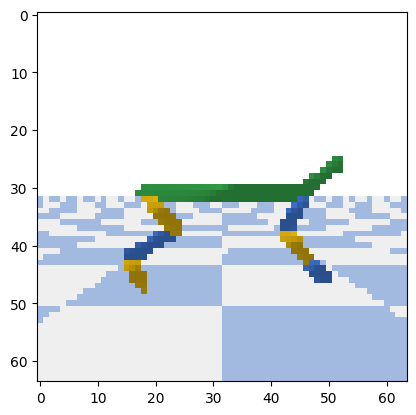

In [8]:
env.reset()
image = env.render(mode='rgb_array')
plt.imshow(image)
plt.show()
env.close()

大分カメラの位置が変わりました. これで元の観測よりはかなり解きやすくなったと思います.

また, より環境を扱いやすくするために, 同じ行動を何度か繰り返すラッパーを挟みます. →時間分解能を減らすということ

In [9]:
class RepeatAction(gym.Wrapper):
    """
    同じ行動を指定された回数自動的に繰り返すラッパー. 観測は最後の行動に対応するものになる
    """
    def __init__(self, env, skip=4):
        gym.Wrapper.__init__(self, env)
        self._skip = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        total_reward = 0.0
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

以上でラッパーに関する話は終わりです. これまでに作成したラッパーをまとめて適用し, 最終的に用いる環境を作成する関数を実装して, 本題のアルゴリズムの実装に移りましょう.

In [10]:
def make_env():
    env = gym.make('HalfCheetahBulletEnv-v0')  # 環境を読み込む. 今回はHalfCheetah
    # Dreamerでは観測は64x64のRGB画像
    env = GymWrapper_PyBullet(env, cam_dist=2, cam_pitch=0, render_width=64, render_height=64)
    env = RepeatAction(env, skip=2)  # DreamerではActionRepeatは2
    return env

## 2. 補助機能の実装

モデルの実装の前に, いくつか学習上必要になる補助機能を実装しておきましょう. 具体的にはリプレイバッファ, 観測の前処理を行う関数, λ-returnを計算する関数 の3つです.

まずはリプレイバッファを実装します. ただし, RNNを使う関係上一連の系列として経験をサンプルしてくる必要があるため, DQNの時よりは少し実装に工夫が必要です.

In [11]:
class ReplayBuffer(object):
    """
    RNNを用いて訓練するのに適したリプレイバッファ
    """
    def __init__(self, capacity, observation_shape, action_dim):
        self.capacity = capacity

        self.observations = np.zeros((capacity, *observation_shape), dtype=np.uint8) # 観測の画像を保存するための配列
        self.actions = np.zeros((capacity, action_dim), dtype=np.float32) # 行動を保存するための配列
        self.rewards = np.zeros((capacity, 1), dtype=np.float32) # 報酬を保存するための配列
        self.done = np.zeros((capacity, 1), dtype=np.bool) # エピソードが終了したかどうかを保存するための配列

        self.index = 0
        self.is_filled = False

    def push(self, observation, action, reward, done):
        """
        リプレイバッファに経験を追加する
        """
        self.observations[self.index] = observation
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.done[self.index] = done

        # indexは巡回し, 最も古い経験を上書きする
        if self.index == self.capacity - 1:
            self.is_filled = True # replay bufferがいっぱいになったらフラグを立てる
        self.index = (self.index + 1) % self.capacity # indexを増やしつつ，capacityを超えたら0に戻す

    def sample(self, batch_size, chunk_length):
        """
        経験をリプレイバッファからサンプルします. （ほぼ）一様なサンプルです
        結果として返ってくるのは(batch_size, chunk_length, 各要素の次元)の配列です
        各バッチは連続した経験になっています
        注意: chunk_lengthをあまり大きな値にすると問題が発生する場合があります
        """
        episode_borders = np.where(self.done)[0] # エピソードの境界を取得
        sampled_indexes = []
        for _ in range(batch_size):
            cross_border = True # サンプルがエピソードの境界をまたぐかどうか
            while cross_border:
                initial_index = np.random.randint(len(self) - chunk_length + 1) # サンプルの開始位置をランダムに選ぶ
                final_index = initial_index + chunk_length - 1 # サンプルの終了位置を決める
                cross_border = np.logical_and(initial_index <= episode_borders, episode_borders < final_index).any() # エピソードの境界をまたぐかどうかを判定
                # cross_borderがtrueならもう一度サンプリングをやり直す
            sampled_indexes += list(range(initial_index, final_index + 1)) # サンプリングしたインデックスを保存

        sampled_observations = self.observations[sampled_indexes].reshape(batch_size, chunk_length, *self.observations.shape[1:]) # サンプリングした観測を取得
        sampled_actions = self.actions[sampled_indexes].reshape(batch_size, chunk_length, self.actions.shape[1])
        sampled_rewards = self.rewards[sampled_indexes].reshape(batch_size, chunk_length, 1)
        sampled_done = self.done[sampled_indexes].reshape(batch_size, chunk_length, 1)
        return sampled_observations, sampled_actions, sampled_rewards, sampled_done # サンプリングした経験を返す

    def __len__(self):
        # len(self)によってリプレイバッファの長さを取得できるようにする
        return self.capacity if self.is_filled else self.index # replay bufferがいっぱいになったらcapacityを返し, そうでなければindexを返す

次に観測の前処理を行う関数を実装します. これは簡単です. ちなみに, これもラッパーとして最初から適用してしまわないのは, リプレイバッファにはより容量の小さなnp.uint8の形式で保存しておきたいためです.

In [12]:
def preprocess_obs(obs):
    """
    画像の変換. [0, 255] -> [-0.5, 0.5]
    """
    obs = obs.astype(np.float32) # これによって[0, 255]の範囲の値が[0.0, 255.0]の範囲の値になる
    normalized_obs = obs / 255.0 - 0.5 # [0.0, 255.0]の範囲の値を[-0.5, 0.5]の範囲の値に変換
    return normalized_obs

Dreamerでは価値関数の学習を行いますが, このために通常のTD誤差ではなく, TD(λ)をベースにしたλ-returnとしてターゲット価値を計算し, それと現在の予測価値の誤差を用います. そのためにλ-returnを計算する関数をここで実装しておきます.  
https://qiita.com/inoz/items/399c225159d25cdb0f85



In [13]:
def lambda_target(rewards, values, gamma, lambda_):
    """
    価値関数の学習のためのλ-returnを計算します
    rewards: 即時報酬の配列
    values: 状態価値の配列
    gamma: 将来報酬の割引率
    lambda_: λ どれだけ遠い未来の報酬を考慮するかを決めるパラメータ。0なら普通のTD誤差
    """
    V_lambda = torch.zeros_like(rewards, device=rewards.device) # rewardsと同じデバイス上にV_lambdaを保存する配列を作成

    H = rewards.shape[0] - 1 # エピソードの長さ?
    V_n = torch.zeros_like(rewards, device=rewards.device)
    V_n[H] = values[H] # 最後のステップの価値はそのまま使う
    for n in range(1, H+1): # n=1~H
        # まずn-step returnを計算します
        # 注意: 系列が途中で終わってしまったら, 可能な中で最大のnを用いたn-stepを使います
        V_n[:-n] = (gamma ** n) * values[n:] # Gt = Rt+1 + γRt+2 + γ^2Rt+3 + ... + γ^(n-1)Rt+n + γ^nVt+nの一番後ろの項
        for k in range(1, n+1): # k=1~n
            if k == n:
                V_n[:-n] += (gamma ** (n-1)) * rewards[k:] # 例外処理
            else:
                V_n[:-n] += (gamma ** (k-1)) * rewards[k:-n+k] # 少しずつインデックスをずらしながら足していく。結果的にはRt+1 + γRt+2 + γ^2Rt+3 + ... + γ^(n-1)Rt+nが加算される

        # lambda_でn-step returnを重みづけてλ-returnを計算します
        if n == H: # 最後のステップの場合
            V_lambda += (lambda_ ** (H-1)) * V_n
        else:
            V_lambda += (1 - lambda_) * (lambda_ ** (n-1)) * V_n # Gtλ = (1-λ)Σλ^(n-1)*Gt

    return V_lambda # Vpi = (1-α)Vpi + αGtλ の右辺のGtλを返す

## 3. モデルの実装
いよいよ本題の世界モデルの実装です. 今回の実装では, Dreamerを以下の6つのクラスに分けて実装します.

* 観測の画像をベクトルに変換するエンコーダクラス（Encoder）
* 状態遷移を担うRecurrent State Space Modelのクラス（RecurrentStateSpaceModel）
* 観測を復元するデコーダクラス（ObservationModel）
* 報酬を予測するクラス（RewardModel）
* 価値関数を計算するクラス（ValueModel）
* 実際に行動を決定するクラス（ActionModel）


まずエンコーダを実装します. ここでは, CNN（Convolutional Neural Network）を用いて, 観測の画像をベクトルに変換します.

In [14]:
class Encoder(nn.Module):
    """
    (3, 64, 64)の画像を(1024,)のベクトルに変換するエンコーダ
    """
    def __init__(self):
        super(Encoder, self).__init__()
        self.cv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2)
        self.cv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.cv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.cv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2)

    def forward(self, obs):
        hidden = F.relu(self.cv1(obs))
        hidden = F.relu(self.cv2(hidden))
        hidden = F.relu(self.cv3(hidden))
        embedded_obs = F.relu(self.cv4(hidden)).reshape(hidden.size(0), -1)
        return embedded_obs

次に実装するのが中核となるRecurrent State Space Modelです. 1ステップ先の未来の状態表現を予測する機能を担います.

学習の方針として, 状態遷移を用いた1ステップ先の未来の状態表現である"prior"と, 1ステップ先の観測の情報を取り込んで計算した状態表現である"posterior"が一致するように学習します.

"posterior"は後に観測の再構成誤差と報酬の予測誤差によって学習されるので, "posterior"は上記の2つの誤差によって妥当な状態表現になるように学習され, 同時に"prior"をそれに近づけることで, 状態表現の空間で未来の予測が可能になるように学習する, というイメージです. よって, これを踏まえたクラスの実装になっています.

状態表現として, 決定的な状態である"rnn_hidden"と, 確率的な状態である"state"の両方を持っています.

In [15]:
class RecurrentStateSpaceModel(nn.Module):
    """
    このクラスは複数の要素を含んでいます.
    決定的状態遷移 （RNN) : h_t+1 = f(h_t, s_t, a_t)
    確率的状態遷移による1ステップ予測として定義される "prior" : p(s_t+1 | h_t+1)
    観測の情報を取り込んで定義される "posterior": q(s_t | h_t, o_t)
    """
    def __init__(self, state_dim, action_dim, rnn_hidden_dim,
                 hidden_dim=200, min_stddev=0.1, act=F.elu):
        super(RecurrentStateSpaceModel, self).__init__()
        self.state_dim = state_dim # 確率的状態の次元
        self.action_dim = action_dim # 行動の次元
        self.rnn_hidden_dim = rnn_hidden_dim # 決定的な状態の次元
        self.fc_state_action = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc_rnn_hidden = nn.Linear(rnn_hidden_dim, hidden_dim)
        self.fc_state_mean_prior = nn.Linear(hidden_dim, state_dim)
        self.fc_state_stddev_prior = nn.Linear(hidden_dim, state_dim)
        self.fc_rnn_hidden_embedded_obs = nn.Linear(rnn_hidden_dim + 1024, hidden_dim)
        self.fc_state_mean_posterior = nn.Linear(hidden_dim, state_dim)
        self.fc_state_stddev_posterior = nn.Linear(hidden_dim, state_dim)
        self.rnn = nn.GRUCell(hidden_dim, rnn_hidden_dim) # RNNはGRUを使う
        self._min_stddev = min_stddev
        self.act = act # 活性化関数

    def forward(self, state, action, rnn_hidden, embedded_next_obs):
        """
        h_t+1 = f(h_t, s_t, a_t) 決定的状態遷移
        prior p(s_t+1 | h_t+1) と posterior p(s_t+1 | h_t+1, o_t+1) を返す
        この2つが近づくように学習する
        """
        next_state_prior, rnn_hidden = self.prior(state, action, rnn_hidden) # prior:1ステップ先の状態の予測 と rnn_hidden:次の決定的な状態の予測を返す
        next_state_posterior = self.posterior(rnn_hidden, embedded_next_obs) # posterior:1ステップ先の観測を基にした状態表現を返す
        return next_state_prior, next_state_posterior, rnn_hidden

    def prior(self, state, action, rnn_hidden):
        """
        h_t+1 = f(h_t, s_t, a_t)
        prior p(s_t+1 | h_t+1) を計算する
        """
        hidden = self.act(self.fc_state_action(torch.cat([state, action], dim=1))) # s_tとa_tを結合して全結合層に通す
        rnn_hidden = self.rnn(hidden, rnn_hidden) # RNNにhiddenとrnn_hiddenを入力して次のrnn_hiddenを得る
        hidden = self.act(self.fc_rnn_hidden(rnn_hidden)) # rnn_hiddenを全結合層に通して活性化関数を適用

        mean = self.fc_state_mean_prior(hidden) # 平均
        stddev = F.softplus(self.fc_state_stddev_prior(hidden)) + self._min_stddev # 標準偏差
        return Normal(mean, stddev), rnn_hidden # 正規分布と次のrnn_hiddenを返す

    def posterior(self, rnn_hidden, embedded_obs):
        """
        posterior q(s_t | h_t, o_t) を計算する
        """
        hidden = self.act(self.fc_rnn_hidden_embedded_obs(torch.cat([rnn_hidden, embedded_obs], dim=1))) # rnn_hiddenとembedded_obsを結合して全結合層に通す
        mean = self.fc_state_mean_posterior(hidden) # 平均
        stddev = F.softplus(self.fc_state_stddev_posterior(hidden)) + self._min_stddev # 標準偏差
        return Normal(mean, stddev) # 正規分布を返す

Mambaを適用するならここ？

次に, 観測を再構成するデコーダを実装します.

In [16]:
class ObservationModel(nn.Module):
    """
    p(o_t | s_t, h_t)
    低次元の状態表現から画像を再構成するデコーダ (3, 64, 64)
    """
    def __init__(self, state_dim, rnn_hidden_dim):
        super(ObservationModel, self).__init__()
        self.fc = nn.Linear(state_dim + rnn_hidden_dim, 1024)
        self.dc1 = nn.ConvTranspose2d(1024, 128, kernel_size=5, stride=2)
        self.dc2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2)
        self.dc3 = nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2)
        self.dc4 = nn.ConvTranspose2d(32, 3, kernel_size=6, stride=2)

    def forward(self, state, rnn_hidden):
        hidden = self.fc(torch.cat([state, rnn_hidden], dim=1)) # 確率的状態 + 決定的状態を結合して全結合層に通してCNNの出力と同じ次元にする
        hidden = hidden.view(hidden.size(0), 1024, 1, 1) # FCの出力をCNNの入力に合わせる
        hidden = F.relu(self.dc1(hidden))
        hidden = F.relu(self.dc2(hidden))
        hidden = F.relu(self.dc3(hidden))
        obs = self.dc4(hidden)
        return obs # 再構成された画像を返す

次に, 報酬を予測するRewardモデルを実装します.

In [17]:
class RewardModel(nn.Module):
    """
    p(r_t | s_t, h_t)
    低次元の状態表現から報酬を予測する
    """
    def __init__(self, state_dim, rnn_hidden_dim, hidden_dim=400, act=F.elu):
        super(RewardModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.act = act

    def forward(self, state, rnn_hidden):
        hidden = self.act(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        reward = self.fc4(hidden)
        return reward

実はここまでの要素は [PlaNet](https://arxiv.org/abs/1811.04551) (Danijar Hafner, Timothy Lillicrap, Ian Fischer, Ruben Villegas, David Ha, Honglak Lee, James Davidson, "Learning Latent Dynamics for Planning from Pixels", ICML2019) と全く同じです. ここからがDreamerとしての中核となる部分で, 端的に言えば世界モデルの学習を通して獲得された低次元の状態表現の上でActor-Criticを行います.


以下で, 価値関数を近似するValueモデルを実装します. Q学習などで用いられる状態行動価値関数Q(s, a)ではなく, 状態価値関数V(s)であることに多少の注意が必要です.

In [18]:
class ValueModel(nn.Module):
    """
    低次元の状態表現から状態価値を出力する
    """
    def __init__(self, state_dim, rnn_hidden_dim, hidden_dim=400, act=F.elu): # eluはReluの改良版 負の値が滑らかに変化する
        super(ValueModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.act = act

    def forward(self, state, rnn_hidden):
        hidden = self.act(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        state_value = self.fc4(hidden)
        return state_value # 状態価値(スカラー)を返す

ここをSACに変更しても面白そう

これでやっと最後です. 実際に行動を出力するActionモデルを実装します.

In [19]:
class ActionModel(nn.Module):
    """
    低次元の状態表現から行動を計算するクラス
    """
    def __init__(self, state_dim, rnn_hidden_dim, action_dim,
                 hidden_dim=400, act=F.elu, min_stddev=1e-4, init_stddev=5.0):
        super(ActionModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, action_dim)
        self.fc_stddev = nn.Linear(hidden_dim, action_dim)
        self.act = act
        self.min_stddev = min_stddev
        self.init_stddev = np.log(np.exp(init_stddev) - 1)

    def forward(self, state, rnn_hidden, training=True):
        """
        training=Trueなら, NNのパラメータに関して微分可能な形の行動のサンプル（Reparametrizationによる）を返します
        training=Falseなら, 行動の確率分布の平均値を返します
        """
        hidden = self.act(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        hidden = self.act(self.fc4(hidden))

        # Dreamerの実装に合わせて少し平均と分散に対する簡単な変換が入っています
        mean = self.fc_mean(hidden) # 平均
        mean = 5.0 * torch.tanh(mean / 5.0)
        stddev = self.fc_stddev(hidden) # 標準偏差
        stddev = F.softplus(stddev + self.init_stddev) + self.min_stddev

        if training:
            action = torch.tanh(Normal(mean, stddev).rsample()) # Reparametrizationによるactionのサンプリング
        else:
            action = torch.tanh(mean) # 単純に平均値（正規分布を確率分布とみた場合，もっとも確率が高い値）を返す
        return action

非常に複雑で大変だったと思います. お疲れ様でした. 実装の詳細まで掴みきれなくとも, 個々のクラスが担っている役割が大雑把にでもわかっていればこの先には進めると思います.

## 4. エージェントの実装

Dreamerでは行動を計算するために低次元の状態表現が必要で, この状態表現は世界モデルを用いて計算されるため, テスト時もこの状態表現のために世界モデルによる推論を行い続ける必要があります. そのため, 先ほど実装したActionModelをそのまま使っても簡単には行動を決定できません. ここを扱いやすくするために, 世界モデルを使って低次元の状態表現を計算しつつ, 行動を決定するAgentクラスを実装します.

In [20]:
class Agent:
    """
    ActionModelに基づき行動を決定する. そのために、世界モデルを用いて状態表現をリアルタイムで推論して維持するクラス
    """
    def __init__(self, encoder, rssm, action_model):
        self.encoder = encoder
        self.rssm = rssm
        self.action_model = action_model

        self.device = next(self.action_model.parameters()).device # デバイスを取得
        self.rnn_hidden = torch.zeros(1, rssm.rnn_hidden_dim, device=self.device)

    def __call__(self, obs, training=True):
        # preprocessを適用, PyTorchのためにChannel-Firstに変換
        obs = preprocess_obs(obs) # 観測の画像を正規化[0, 255] -> [-0.5, 0.5]
        obs = torch.as_tensor(obs, device=self.device) # numpy配列をtorchテンソルに変換
        obs = obs.transpose(1, 2).transpose(0, 1).unsqueeze(0) # 次元を入れ替え

        with torch.no_grad():
            # 観測を低次元の表現に変換し, posteriorからのサンプルをActionModelに入力して行動を決定する
            embedded_obs = self.encoder(obs) # CNNで観測を低次元の表現に変換
            state_posterior = self.rssm.posterior(self.rnn_hidden, embedded_obs) # obsを基にした状態表現を取得
            state = state_posterior.sample() # 状態表現のサンプリング
            action = self.action_model(state, self.rnn_hidden, training=training) # 状態表現を基にした行動を取得

            # 次のステップのためにRNNの隠れ状態を更新しておく
            _, self.rnn_hidden = self.rssm.prior(state, action, self.rnn_hidden) # 次の隠れ状態を取得

        return action.squeeze().cpu().numpy() # 行動を返す

    def reset(self):
        self.rnn_hidden = torch.zeros(1, self.rssm.rnn_hidden_dim, device=self.device) # RNNの隠れ状態をリセット

## 5. ハイパーパラメータの設定と学習の準備

ここまででDreamerの基本的な構成要素は実装が終わりました. あとはハイパーパラメータを設定し, モデルやリプレイバッファを宣言して学習の準備を整えます.

In [21]:
# リプレイバッファの宣言
buffer_capacity = 200000  # Colabのメモリの都合上, 元の実装より小さめにとっています
replay_buffer = ReplayBuffer(capacity=buffer_capacity,
                              observation_shape=env.observation_space.shape,
                              action_dim=env.action_space.shape[0])

# モデルの宣言
state_dim = 30  # 確率的状態の次元
rnn_hidden_dim = 200  # 決定的状態（RNNの隠れ状態）の次元
encoder = Encoder().to(device) # 画像のエンコーダ CNN
rssm = RecurrentStateSpaceModel(state_dim, env.action_space.shape[0], rnn_hidden_dim).to(device) # 世界モデル RSSM
obs_model = ObservationModel(state_dim, rnn_hidden_dim).to(device) # 画像の再構成モデル デコーダ
reward_model = RewardModel(state_dim, rnn_hidden_dim).to(device) # 報酬予測モデル
value_model = ValueModel(state_dim, rnn_hidden_dim).to(device) # 状態価値モデル
action_model = ActionModel(state_dim, rnn_hidden_dim, env.action_space.shape[0]).to(device) # 行動モデル

# オプティマイザの宣言
model_lr = 6e-4  # encoder, rssm, obs_model, reward_modelの学習率
value_lr = 8e-5
action_lr = 8e-5
eps = 1e-4
model_params = (list(encoder.parameters()) +
                  list(rssm.parameters()) +
                  list(obs_model.parameters()) +
                  list(reward_model.parameters()))
model_optimizer = torch.optim.Adam(model_params, lr=model_lr, eps=eps)
value_optimizer = torch.optim.Adam(value_model.parameters(), lr=value_lr, eps=eps)
action_optimizer = torch.optim.Adam(action_model.parameters(), lr=action_lr, eps=eps)

# その他ハイパーパラメータ
seed_episodes = 5  # 最初にランダム行動で探索するエピソード数
all_episodes = 100  # 学習全体のエピソード数（300ほどである程度収束します）
test_interval = 10  # 何エピソードごとに探索ノイズなしのテストを行うか
model_save_interval = 20  # NNの重みを何エピソードごとに保存するか
collect_interval = 100  # 何回のNNの更新ごとに経験を集めるか（＝1エピソード経験を集めるごとに何回更新するか）

action_noise_var = 0.3  # 探索ノイズの強さ

batch_size = 50
chunk_length = 50  # 1回の更新で用いる系列の長さ
imagination_horizon = 15  # Actor-Criticの更新のために, Dreamerで何ステップ先までの想像上の軌道を生成するか

gamma = 0.9  # 割引率
lambda_ = 0.95  # λ-returnのパラメータ
clip_grad_norm = 100  # gradient clippingの値
free_nats = 3  # KL誤差（RSSMのpriorとposteriorの間の誤差）がこの値以下の場合, 無視する

<ipython-input-11-4e1db3198249>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.done = np.zeros((capacity, 1), dtype=np.bool)


## 6. 学習
まず, 最初の数エピソードはランダムに行動して経験をリプレイバッファに貯めます.

In [22]:
env = make_env()
for episode in range(seed_episodes):
    obs = env.reset() # 環境をリセットして観測を取得
    done = False
    while not done:
        action = env.action_space.sample() # ランダムに行動を選択
        next_obs, reward, done, _ = env.step(action) # 行動を環境に渡して次の観測, 報酬, エピソードが終了したかどうかを取得
        replay_buffer.push(obs, action, reward, done) # 経験をリプレイバッファに追加
        obs = next_obs # 観測を更新

学習経過をリアルタイムに確認するために, TensorBoardを立ち上げておきます.

In [ ]:
log_dir = 'logs'
writer = SummaryWriter(log_dir)
%tensorboard --logdir='./logs'

以下がメインの学習ループです. 分割するわけにいかないので長くなっていまいましたが, 細かくコメントをつけたので, 少しずつ追っていってください.

In [ ]:
for episode in range(seed_episodes, all_episodes):
    # -----------------------------
    #      経験を集める
    # -----------------------------
    start = time.time()
    # 行動を決定するためのエージェントを宣言
    policy = Agent(encoder, rssm, action_model)

    obs = env.reset()
    done = False
    total_reward = 0
    while not done: # 1エピソード分の経験を集める
        action = policy(obs)
        # 探索のためにガウス分布に従うノイズを加える
        action += np.random.normal(0, np.sqrt(action_noise_var), env.action_space.shape[0])
        next_obs, reward, done, _ = env.step(action)
        replay_buffer.push(obs, action, reward, done)
        obs = next_obs
        total_reward += reward

    # 訓練時の報酬と経過時間をログとして表示
    writer.add_scalar('total reward at train', total_reward, episode)
    print('episode [%4d/%4d] is collected. Total reward is %f' %
            (episode+1, all_episodes, total_reward))
    print('elasped time for interaction: %.2fs' % (time.time() - start))

    # NNのパラメータを更新する
    start = time.time()
    for update_step in range(collect_interval):
        # -----------------------------------------------------------------
        #  encoder, rssm, obs_model, reward_modelの更新
        # -----------------------------------------------------------------
        observations, actions, rewards, _ = replay_buffer.sample(batch_size, chunk_length)

        # 観測を前処理し, RNNを用いたPyTorchでの学習のためにTensorの次元を調整
        observations = preprocess_obs(observations) # 観測の画像を正規化[0, 255] -> [-0.5, 0.5] int8 -> float32
        observations = torch.as_tensor(observations, device=device) # numpy配列をtorchテンソルに変換
        observations = observations.transpose(3, 4).transpose(2, 3) # 次元を入れ替え
        observations = observations.transpose(0, 1)
        actions = torch.as_tensor(actions, device=device).transpose(0, 1) # 行動をテンソルに変換
        rewards = torch.as_tensor(rewards, device=device).transpose(0, 1) # 報酬をテンソルに変換

        # 観測をエンコーダで低次元のベクトルに変換
        embedded_observations = encoder(observations.reshape(-1, 3, 64, 64)).view(chunk_length, batch_size, -1) # CNNで観測を低次元の表現に変換

        # 低次元の状態表現を保持しておくためのTensorを定義
        states = torch.zeros(chunk_length, batch_size, state_dim, device=device)
        rnn_hiddens = torch.zeros(chunk_length, batch_size, rnn_hidden_dim, device=device)

        # 低次元の状態表現は最初はゼロ初期化
        state = torch.zeros(batch_size, state_dim, device=device)
        rnn_hidden = torch.zeros(batch_size, rnn_hidden_dim, device=device)

        # 状態予測を行ってそのロスを計算する（priorとposteriorの間のKLダイバージェンス）
        kl_loss = 0
        for l in range(chunk_length-1): # chunk_length回繰り返す
            next_state_prior, next_state_posterior, rnn_hidden = rssm(state, actions[l], rnn_hidden, embedded_observations[l+1]) # obsはl+1のものを使う
            state = next_state_posterior.rsample() # 状態表現のサンプリング
            states[l+1] = state # 状態表現を保存
            rnn_hiddens[l+1] = rnn_hidden # 決定的な状態を保存
            kl = kl_divergence(next_state_prior, next_state_posterior).sum(dim=1) # KLダイバージェンスを計算
            kl_loss += kl.clamp(min=free_nats).mean()  # 原論文通り, KL誤差がfree_nats以下の時は無視
        kl_loss /= (chunk_length - 1)

        # states[0] and rnn_hiddens[0]はゼロ初期化なので以降では使わない
        states = states[1:]
        rnn_hiddens = rnn_hiddens[1:]

        # 観測を再構成, また, 報酬を予測
        flatten_states = states.view(-1, state_dim) # chunk_length-1 * batch_size, state_dim
        flatten_rnn_hiddens = rnn_hiddens.view(-1, rnn_hidden_dim) # chunk_length-1 * batch_size, rnn_hidden_dim
        recon_observations = obs_model(flatten_states, flatten_rnn_hiddens).view(chunk_length-1, batch_size, 3, 64, 64) # 再構成された画像を取得
        predicted_rewards = reward_model(flatten_states, flatten_rnn_hiddens).view(chunk_length-1, batch_size, 1) # 予測された報酬を取得

        # 観測と報酬の予測誤差を計算
        obs_loss = 0.5 * F.mse_loss(recon_observations, observations[1:], reduction='none').mean([0, 1]).sum() # 再構成された観測のmse(平均二乗)誤差
        reward_loss = 0.5 * F.mse_loss(predicted_rewards, rewards[:-1]) # 予測された報酬のmse(平均二乗)誤差

        # 以上のロスを合わせて勾配降下で更新する
        model_loss = kl_loss + obs_loss + reward_loss
        model_optimizer.zero_grad()
        model_loss.backward() # エンコーダ，デコーダ，報酬予測モデル，RSSMのパラメータに対して勾配を計算
        clip_grad_norm_(model_params, clip_grad_norm) # 勾配の大きさを制限(クリッピング)
        model_optimizer.step() # パラメータを更新

        # ----------------------------------------------
        #  Action Model, Value　Modelの更新
        # ----------------------------------------------
        # Actor-Criticのロスで他のモデルを更新することはないので勾配の流れを一度遮断
        flatten_states = flatten_states.detach()
        flatten_rnn_hiddens = flatten_rnn_hiddens.detach()

        # DreamerにおけるActor-Criticの更新のために, 現在のモデルを用いた
        # 数ステップ先の未来の状態予測を保持するためのTensorを用意
        imaginated_states = torch.zeros(imagination_horizon + 1,
                                         *flatten_states.shape,
                                          device=flatten_states.device)
        imaginated_rnn_hiddens = torch.zeros(imagination_horizon + 1,
                                                *flatten_rnn_hiddens.shape,
                                                device=flatten_rnn_hiddens.device)

        #　未来予測をして想像上の軌道を作る前に, 最初の状態としては先ほどモデルの更新で使っていた
        # リプレイバッファからサンプルされた観測データを取り込んだ上で推論した状態表現を使う
        imaginated_states[0] = flatten_states # flatten_statesはリプレイバッファからサンプルされた観測データを畳み込んで再構成した状態表現のchunk_length-1*batch_sizeのテンソル
        imaginated_rnn_hiddens[0] = flatten_rnn_hiddens # flatten_rnn_hiddensはリプレイバッファからサンプルされたデータから推論した決定的な状態のテンソル

        # open-loopで未来の状態予測を使い, 想像上の軌道を作る
        for h in range(1, imagination_horizon + 1):
            # 行動はActionModelで決定. この行動はモデルのパラメータに対して微分可能で,
            #　これを介してActionModelは更新される
            actions = action_model(flatten_states, flatten_rnn_hiddens)
            flatten_states_prior, flatten_rnn_hiddens = rssm.prior(flatten_states, actions, flatten_rnn_hiddens)
            flatten_states = flatten_states_prior.rsample()
            imaginated_states[h] = flatten_states
            imaginated_rnn_hiddens[h] = flatten_rnn_hiddens

        # 予測された架空の軌道に対する報酬を計算
        flatten_imaginated_states = imaginated_states.view(-1, state_dim)
        flatten_imaginated_rnn_hiddens = imaginated_rnn_hiddens.view(-1, rnn_hidden_dim)
        imaginated_rewards = reward_model(flatten_imaginated_states, flatten_imaginated_rnn_hiddens).view(imagination_horizon + 1, -1)
        imaginated_values = value_model(flatten_imaginated_states, flatten_imaginated_rnn_hiddens).view(imagination_horizon + 1, -1)
        # λ-returnのターゲットを計算
        lambda_target_values = lambda_target(imaginated_rewards, imaginated_values, gamma, lambda_)

        # 価値関数の予測した価値が大きくなるようにActionModelを更新
        # PyTorchの基本は勾配降下だが, 今回は大きくしたいので-1をかける
        action_loss = -1 * (lambda_target_values.mean())
        action_optimizer.zero_grad()
        action_loss.backward()
        clip_grad_norm_(action_model.parameters(), clip_grad_norm)
        action_optimizer.step()

        # Value Modelの学習用に価値観数を再度計算
        imaginated_values = value_model(flatten_imaginated_states.detach(), flatten_imaginated_rnn_hiddens.detach()).view(imagination_horizon + 1, -1)
        lambda_target_values = lambda_target(imaginated_rewards.detach(), imaginated_values, gamma, lambda_)

        # TD(λ)ベースの目的関数で価値関数を更新
        value_loss = 0.5 * F.mse_loss(imaginated_values, lambda_target_values.detach())
        value_optimizer.zero_grad()
        value_loss.backward()
        clip_grad_norm_(value_model.parameters(), clip_grad_norm)
        value_optimizer.step()

        # # TD(λ)ベースの目的関数で価値関数を更新
        # value_loss = 0.5 * F.mse_loss(imaginated_values, lambda_target_values.detach())
        # value_optimizer.zero_grad()
        # value_loss.backward(retain_graph=True)
        # clip_grad_norm_(value_model.parameters(), clip_grad_norm)
        # value_optimizer.step()

        # ログをTensorBoardに出力
        print('update_step: %3d model loss: %.5f, kl_loss: %.5f, '
             'obs_loss: %.5f, reward_loss: %.5f, '
             'value_loss: %.5f action_loss: %.5f'
                % (update_step + 1, model_loss.item(), kl_loss.item(),
                    obs_loss.item(), reward_loss.item(),
                    value_loss.item(), action_loss.item()))
        total_update_step = episode * collect_interval + update_step
        writer.add_scalar('model loss', model_loss.item(), total_update_step)
        writer.add_scalar('kl loss', kl_loss.item(), total_update_step)
        writer.add_scalar('obs loss', obs_loss.item(), total_update_step)
        writer.add_scalar('reward loss', reward_loss.item(), total_update_step)
        writer.add_scalar('value loss', value_loss.item(), total_update_step)
        writer.add_scalar('action loss', action_loss.item(), total_update_step)

    print('elasped time for update: %.2fs' % (time.time() - start))

    # --------------------------------------------------------------
    #    テストフェーズ. 探索ノイズなしでの性能を評価する
    # --------------------------------------------------------------
    if (episode + 1) % test_interval == 0:
        policy = Agent(encoder, rssm, action_model)
        start = time.time()
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = policy(obs, training=False)
            obs, reward, done, _ = env.step(action)
            total_reward += reward

        writer.add_scalar('total reward at test', total_reward, episode)
        print('Total test reward at episode [%4d/%4d] is %f' %
                (episode+1, all_episodes, total_reward))
        print('elasped time for test: %.2fs' % (time.time() - start))

    if (episode + 1) % model_save_interval == 0:
        # 定期的に学習済みモデルのパラメータを保存する
        model_log_dir = os.path.join(log_dir, 'episode_%04d' % (episode + 1))
        os.makedirs(model_log_dir)
        torch.save(encoder.state_dict(), os.path.join(model_log_dir, 'encoder.pth'))
        torch.save(rssm.state_dict(), os.path.join(model_log_dir, 'rssm.pth'))
        torch.save(obs_model.state_dict(), os.path.join(model_log_dir, 'obs_model.pth'))
        torch.save(reward_model.state_dict(), os.path.join(model_log_dir, 'reward_model.pth'))
        torch.save(value_model.state_dict(), os.path.join(model_log_dir, 'value_model.pth'))
        torch.save(action_model.state_dict(), os.path.join(model_log_dir, 'action_model.pth'))

writer.close()

episode [   6/ 100] is collected. Total reward is -1640.657327
elasped time for interaction: 4.29s
update_step:   1 model loss: 1289.27393, kl_loss: 3.00000, obs_loss: 1281.70215, reward_loss: 4.57177, value_loss: 0.10419 action_loss: 0.42563
update_step:   2 model loss: 1267.96436, kl_loss: 3.00000, obs_loss: 1260.48950, reward_loss: 4.47485, value_loss: 0.36312 action_loss: 0.80539
update_step:   3 model loss: 1238.95886, kl_loss: 3.00000, obs_loss: 1231.70703, reward_loss: 4.25187, value_loss: 0.82279 action_loss: 1.21837
update_step:   4 model loss: 1213.05957, kl_loss: 3.00000, obs_loss: 1205.58984, reward_loss: 4.46972, value_loss: 1.57794 action_loss: 1.69127
update_step:   5 model loss: 1155.78601, kl_loss: 3.00000, obs_loss: 1148.99683, reward_loss: 3.78925, value_loss: 2.83196 action_loss: 2.26608
update_step:   6 model loss: 1060.46216, kl_loss: 3.00000, obs_loss: 1054.10791, reward_loss: 3.35426, value_loss: 4.90771 action_loss: 2.98027
update_step:   7 model loss: 916.0678

KeyboardInterrupt: 

## 7. 結果の確認
保存された学習済み重みを用いて, 動作を確認してみましょう.

学習にはかなりの時間がかかるので, ここでは事前に学習しておいた重みを読み込むことにします. 時間のある方は, 上記のコードで実際に学習した重みを使って同様に試してみてください.

In [23]:
# 事前にGoogle Driveにあげておいた学習済み重みをダウンロードします
from google_drive_downloader import GoogleDriveDownloader as gdd
# gdd.download_file_from_google_drive(file_id='1-w0-9sqVAGbTsvJkDIhoFZj2j9WzGaYz',
gdd.download_file_from_google_drive(file_id='18SgmYkPkGlzgQI-dlvWX5herqMY-RQlT',
                                       dest_path='./episode_1000.zip',
                                       unzip=True)

Unzipping...Done.


In [24]:
# 学習済み重みを用いず, このcolab上で学習したモデルを使うなら, 単にこのセルをスキップすれば良いです
# あるいは, 定期的に保存されているモデルを読み込むこともできます
encoder.load_state_dict(torch.load('./episode_1000/encoder.pth'))
rssm.load_state_dict(torch.load('./episode_1000/rssm.pth'))
obs_model.load_state_dict(torch.load('./episode_1000/obs_model.pth'))
action_model.load_state_dict(torch.load('./episode_1000/action_model.pth'))

<All keys matched successfully>

せっかくなので, 動作の様子を動画で観てみることにします.

In [25]:
# 結果を動画で観てみるための関数
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


def display_video(frames):
    plt.figure(figsize=(8, 8), dpi=50)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
        plt.title("Step %d" % (i))

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(HTML(anim.to_jshtml(default_mode='once')))
    plt.close()

In [26]:
policy = Agent(encoder, rssm, action_model)
obs = env.reset()
done = False
total_reward = 0
frames = [obs]
while not done:
    action = policy(obs, training=False)
    obs, reward, done, _ = env.step(action)
    total_reward += reward
    frames.append(obs)

print('Total Reward:', total_reward)

Total Reward: 2552.1420912908525


In [27]:
display_video(frames)

ある時点の適当な観測から, 世界モデルで**open-loopに**未来予測を行わせ, 観測を再構成して視覚的に観てみましょう.

In [28]:
policy = Agent(encoder, rssm, action_model)
obs = env.reset()
# 最初に適当な回数行動します. この間にrnn_hiddenに観測の系列に関する情報が蓄積されます
for _ in range(np.random.randint(5, 100)):
    action = policy(obs, training=False)
    obs, _, _, _ = env.step(action)

# 現在の観測をベクトルに変換し, それを元にposteriorを計算します.
preprocessed_obs = preprocess_obs(obs)
preprocessed_obs = torch.as_tensor(preprocessed_obs, device=device)
preprocessed_obs = preprocessed_obs.transpose(1, 2).transpose(0, 1).unsqueeze(0)
with torch.no_grad():
    embedded_obs = encoder(preprocessed_obs)

# posteriorからのサンプルとして得られたstateと, policyから取得したrnn_hiddenが低次元の状態表現です.
# open-loopの予測なので, これ以降この2つの変数は状態遷移を表すpriorでしか更新しません.
# （policyの中では, 行動を決定するために観測をリアルタイムで反映してposteriorで更新しています）
rnn_hidden = policy.rnn_hidden
state = rssm.posterior(rnn_hidden, embedded_obs).sample()
frame = np.zeros((64, 128, 3))
frames = []

prediction_length = 100
for _ in range(prediction_length):
    action = policy(obs)
    obs, _, _, _ = env.step(action)

    action = torch.as_tensor(action, device=device).unsqueeze(0)
    with torch.no_grad():
        state_prior, rnn_hidden = rssm.prior(state, action, rnn_hidden)
        state = state_prior.sample()
        predicted_obs = obs_model(state, rnn_hidden)

    frame[:, :64, :] = preprocess_obs(obs)
    frame[:, 64:, :] = predicted_obs.squeeze().transpose(0, 1).transpose(1, 2).cpu().numpy()
    frames.append((frame + 0.5).clip(0.0, 1.0))

open-loopの動画予測の結果を, 左側に真のフレーム, 右側に予測されたフレームと並べてみてみましょう.

In [29]:
display_video(frames)

これにて演習は終わりです. お疲れ様でした！